<a href="https://colab.research.google.com/github/J-A-S-H-U/Hardware_for_AI_ML/blob/main/SAXPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Python 3.11.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [9]:
%%cuda
#include <stdio.h>
#include <cuda_runtime.h>
#include <math.h>

__global__
void saxpy(int n, float a, float *x, float *y) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = a * x[i] + y[i];
}

int main() {
    int start_power = 15;
    int end_power = 25;
    int threadsPerBlock = 256;

    printf("N,TotalTime(ms),KernelTime(ms)\n");

    for (int p = start_power; p <= end_power; p++) {
        int N = 1 << p;
        float *x, *y, *d_x, *d_y;

        cudaEvent_t startTotal, stopTotal, startKernel, stopKernel;
        cudaEventCreate(&startTotal);
        cudaEventCreate(&stopTotal);
        cudaEventCreate(&startKernel);
        cudaEventCreate(&stopKernel);

        cudaEventRecord(startTotal);
        x = (float*)malloc(N * sizeof(float));
        y = (float*)malloc(N * sizeof(float));

        cudaMalloc(&d_x, N * sizeof(float));
        cudaMalloc(&d_y, N * sizeof(float));

        for (int i = 0; i < N; i++) {
            x[i] = 1.0f;
            y[i] = 2.0f;
        }

        cudaMemcpy(d_x, x, N * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, y, N * sizeof(float), cudaMemcpyHostToDevice);

        // Start kernel timing
        cudaEventRecord(startKernel);
        saxpy<<<(N + threadsPerBlock - 1) / threadsPerBlock, threadsPerBlock>>>(N, 2.0f, d_x, d_y);
        cudaEventRecord(stopKernel);

        cudaMemcpy(y, d_y, N * sizeof(float), cudaMemcpyDeviceToHost);

        // Stop total timing
        cudaEventRecord(stopTotal);
        cudaEventSynchronize(stopTotal);
        cudaEventSynchronize(stopKernel);

        float totalTime = 0.0f, kernelTime = 0.0f;
        cudaEventElapsedTime(&totalTime, startTotal, stopTotal);
        cudaEventElapsedTime(&kernelTime, startKernel, stopKernel);

        printf("%d,%f,%f\n", N, totalTime, kernelTime);

        cudaFree(d_x);
        cudaFree(d_y);
        free(x);
        free(y);

        cudaEventDestroy(startTotal);
        cudaEventDestroy(stopTotal);
        cudaEventDestroy(startKernel);
        cudaEventDestroy(stopKernel);
    }

    return 0;
}


N,TotalTime(ms),KernelTime(ms)
32768,7.969888,7.463328
65536,0.566048,0.002976
131072,1.003776,0.002624
262144,1.930752,0.002752
524288,3.999168,0.002624
1048576,8.924128,0.002656
2097152,17.150593,0.002624
4194304,34.490208,0.002592
8388608,75.173508,0.002624
16777216,141.689407,0.002656
33554432,288.343781,0.003072



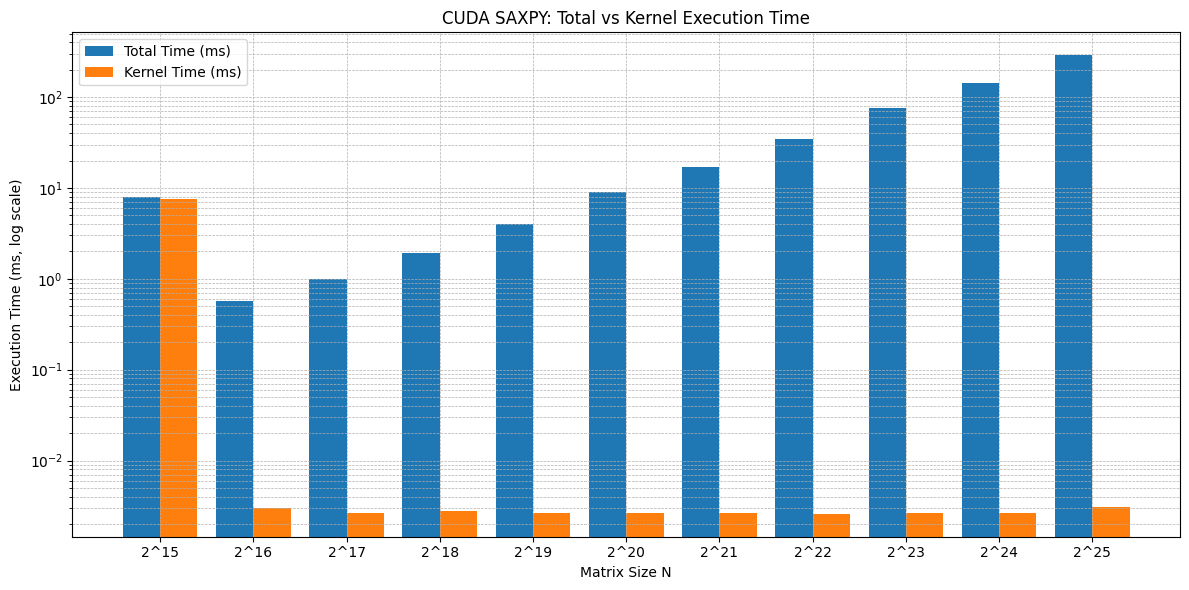

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Input data from CUDA output
N_values = [
    32768, 65536, 131072, 262144, 524288, 1048576,
    2097152, 4194304, 8388608, 16777216, 33554432
]
Total_time = [
    7.969888, 0.566048, 1.003776, 1.930752, 3.999168,
    8.924128, 17.150593, 34.490208, 75.173508,
    141.689407, 288.343781
]
Kernel_time = [
    7.463328, 0.002976, 0.002624, 0.002752, 0.002624,
    0.002656, 0.002624, 0.002592, 0.002624,
    0.002656, 0.003072
]

# Create x-axis labels as powers of 2
labels = [f"2^{int(np.log2(n))}" for n in N_values]
x = np.arange(len(N_values))
bar_width = 0.4

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, Total_time, width=bar_width, label='Total Time (ms)')
plt.bar(x + bar_width / 2, Kernel_time, width=bar_width, label='Kernel Time (ms)')

plt.xticks(x, labels)
plt.yscale('log')  # Log scale for clarity
plt.xlabel("Matrix Size N")
plt.ylabel("Execution Time (ms, log scale)")
plt.title("CUDA SAXPY: Total vs Kernel Execution Time")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
